# ML Beyond Prediction: Explainable AI

In [1]:
!pip install --quiet  dice_ml sklearndf gamma-facet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 19.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 1.5.3 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 1.5.3 wh

### Diverse Counterfactual Explanations (DICE)

#### Dataset

The `load_breast_cancer` dataset from scikit-learn is a collection of data related to breast cancer diagnosis.

Key points:

`Purpose`: The dataset is primarily used for classification tasks, where the goal is to predict whether a breast tumor is malignant (cancerous) or benign (non-cancerous) based on various features.

`Features`: It includes 30 features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. These features describe characteristics of the cell nuclei present in the image, such as radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, and fractal dimension (both mean and standard error, and also the "worst" or largest of these features).   

`Target Variable`: The target variable is binary, indicating whether the tumor is 'malignant' or 'benign'.

`Size`: It typically contains around 569 samples (instances or patients) and 30 features.

#### Code

The code below trains a Random Forest classifier on the breast cancer dataset and then uses the DiCE (via dice-ml library)  to generate and visualize counterfactual examples that would lead to a different prediction for a specific instance.

In [2]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import dice_ml

In [3]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data,
                 columns=data.feature_names)
y = pd.Series(data.target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [4]:
# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9649122807017544


In [5]:
# Create a DiCE explainer
d = dice_ml.Data(dataframe=X_train.assign(target=y_train),
                 continuous_features=list(X.columns),
                 outcome_name='target')

m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")

In [6]:
# Choose a query instance from the test set (e.g., the seecond instance)
query_instance = X_test.iloc[[1]]

# Generate counterfactual explanations
dice_exp = exp.generate_counterfactuals(query_instance,
                                        total_CFs=3,
                                        desired_class="opposite")

100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


In [7]:
# Display the explanations
print(dice_exp.visualize_as_dataframe(show_only_changes=True))

Query instance (original outcome : 0)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,18.940001,21.309999,123.599998,1130.0,0.09009,0.1029,0.108,0.07951,0.1582,0.05461,...,26.58,165.899994,1866.0,0.1193,0.2336,0.2687,0.1789,0.2551,0.06589,0



Diverse Counterfactual set (new outcome: 1)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,10.12,12.68,58.37,932.0,0.118,0.0635,0.4,-,-,0.05091,...,-,86.3,829.9,-,-,0.7,0.1,-,0.06356,1.0
1,-,-,76.1,1430.9,0.071,-,0.3,0.1,-,-,...,-,90.5,611.4,0.16,0.2346000000000011,-,0.1,0.4436,0.0572,-
2,10.12,12.68,58.37,932.0,0.118,0.0635,0.4,-,-,0.05091,...,-,86.3,829.9,-,-,-,0.1,-,0.06356,1.0


None


Three CFs are presented with proposed changes in such features as worst perimeter, worst area, worst concave points, etc to flip the class from 0 (benign tumor) to 1 (malignant tumor).

### Gamma FACET

#### Dataset

The California housing dataset will be used: It contains information about various characteristics of houses in different blocks in California.

`Target Variable`: The main goal is to predict the median house value for each block.
  
`Features`: The dataset provides several features that might influence house prices, such as:
- Median income of the block
- Housing median age
- Total rooms
- Total bedrooms
- Population
- Households
- Latitude
- Longitude

Source: The dataset is derived from the 1990 California census data.


#### Code

In [8]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

# some helpful imports from sklearndf
from sklearndf.pipeline import RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF

# relevant FACET imports
from facet.data import Sample
from facet.inspection import LearnerInspector

In [9]:
# Load the california housing dataset
housing = fetch_california_housing()

# Create a DataFrame with the features and the target variable
data = housing
# Select the first 500 samples
X = pd.DataFrame(data.data[:500], columns=data.feature_names)
y = pd.Series(data.target[:500])

# Create a new DataFrame that includes the target variable
df = pd.concat([X, pd.DataFrame(y, columns=['target'])], axis=1)

# create FACET sample object
housing_sample = Sample(observations=df, target_name="target")

# Create a Random Forest regressor with fixed hyperparameters
rnd_forest_reg = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(n_estimators=100, random_state=42)
)

# Fit the regressor (no hyperparameter tuning here)
rnd_forest_reg.fit(X, y)

RegressorPipelineDF(regressor=RandomForestRegressorDF(random_state=42))

In [10]:
# fit the model inspector
inspector = LearnerInspector(
    model=rnd_forest_reg,
    n_jobs=-3
).fit(housing_sample)

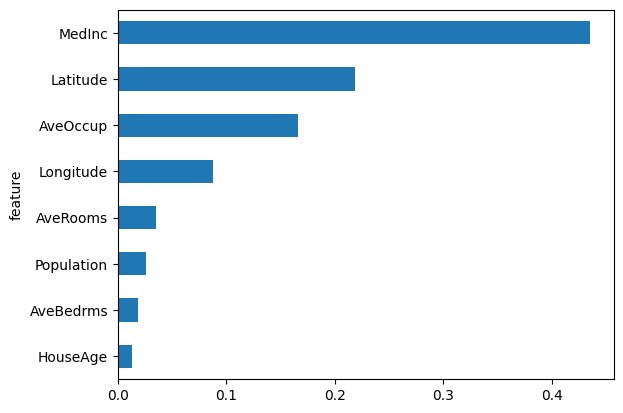

In [22]:
inspector.feature_importance().sort_values(ascending=True).plot(kind='barh')

# Save as a high-quality PNG
plt.savefig('feat_imp.png', dpi=300, bbox_inches='tight')

**Synergy Matrix**

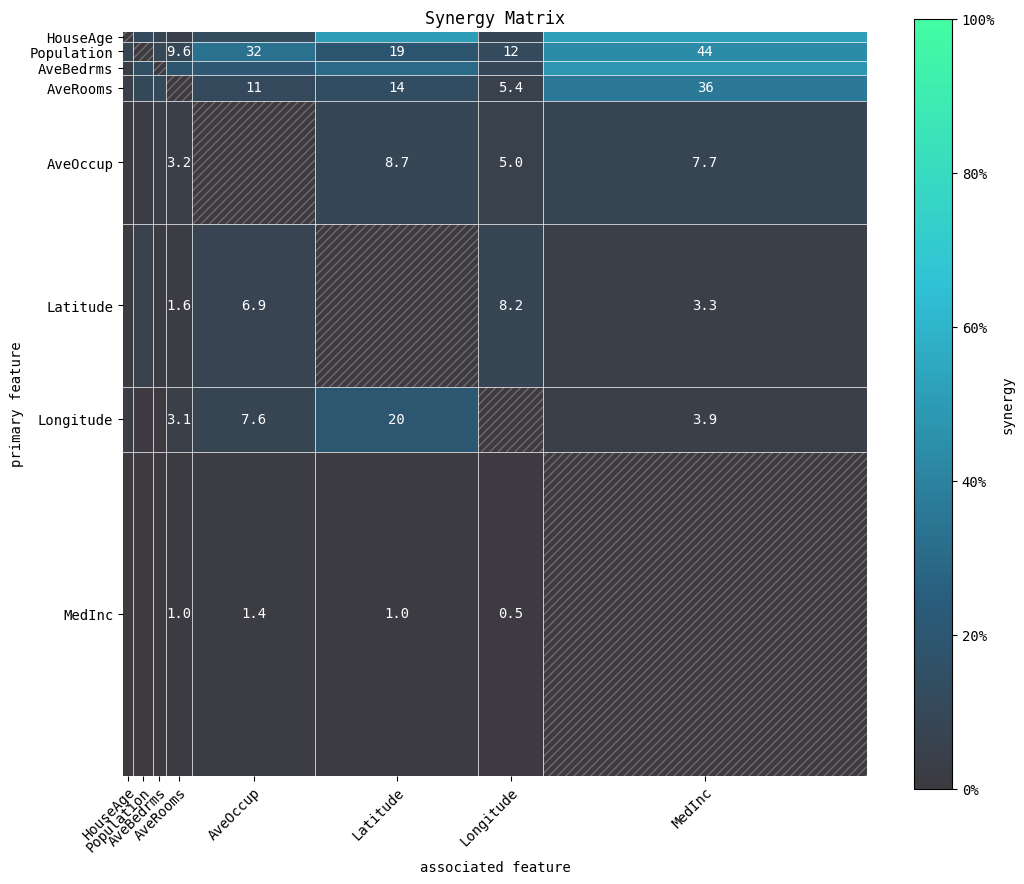

In [18]:
# visualise synergy as a matrix
from pytools.viz.matrix import MatrixDrawer

# Increase the figure size
plt.figure(figsize=(12, 10))
#plt.figure(figsize=(20, 16))

synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix,
                                    title="Synergy Matrix")

# Save as a high-quality PNG
#plt.savefig('synergy_matrix.png', dpi=300, bbox_inches='tight')

**Redundancy Matrix**

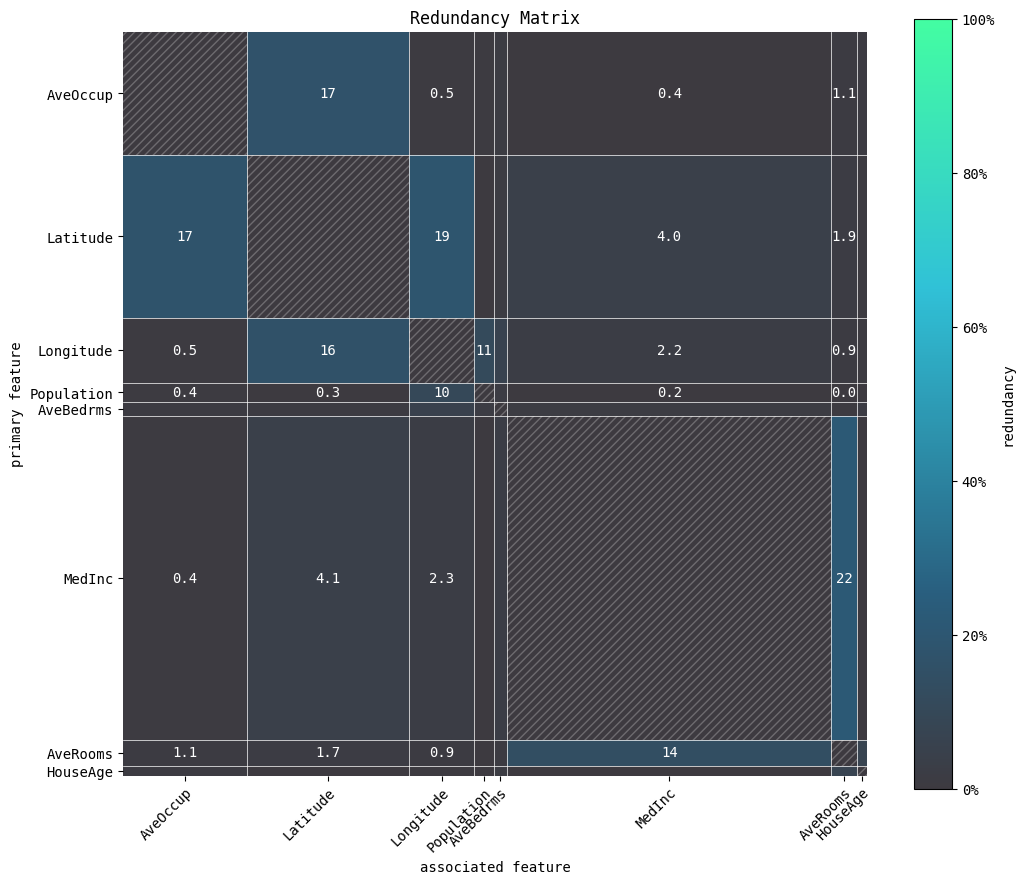

In [19]:
# Increase the figure size
plt.figure(figsize=(12, 10))

# visualise redundancy as a matrix
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix,
                                    title="Redundancy Matrix")
# Save as a high-quality PNG
#plt.savefig('redundancy_matrix.png', dpi=300, bbox_inches='tight')

**Redundancy Dendrogram**

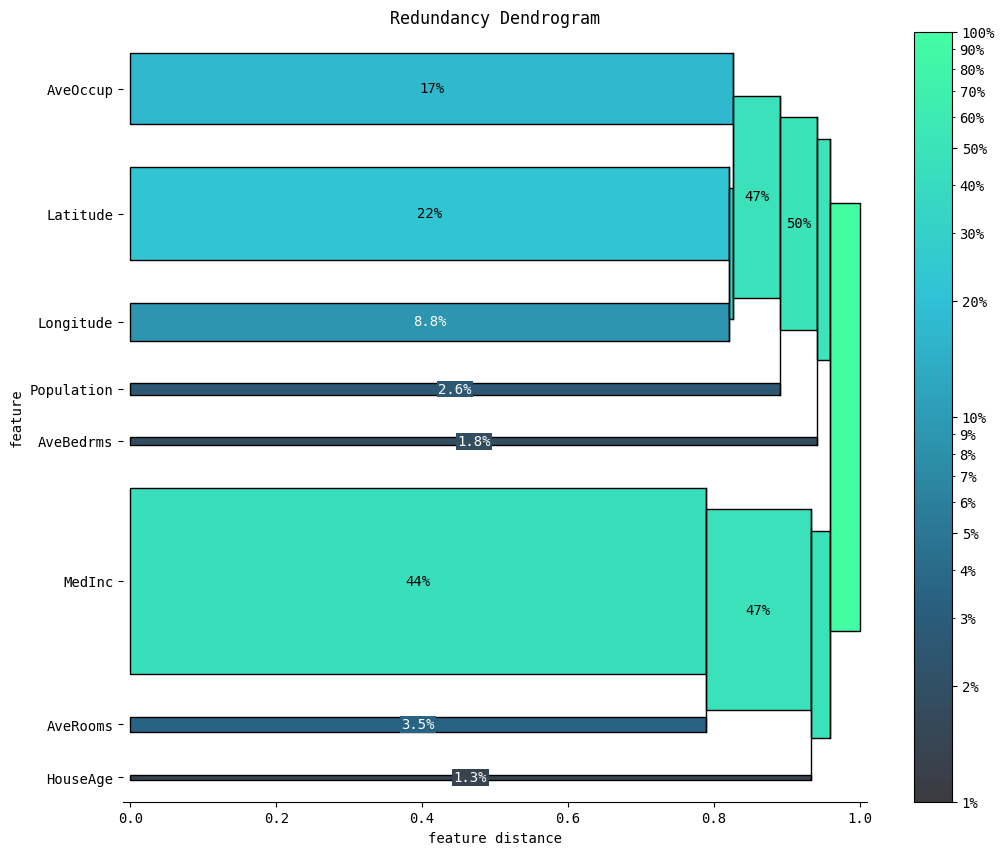

In [20]:
# Increase the figure size
plt.figure(figsize=(12, 10))

# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy,
                        title="Redundancy Dendrogram")

# Save as a high-quality PNG
#plt.savefig('redundancy_dendrogram.png', dpi=300, bbox_inches='tight')